# Custom Modifiers

In [1]:
import pyhf
import pyhf.modifiers
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

In [2]:
class custom_modifier_builder:
    def __init__(self, pdfconfig):
        self.config = pdfconfig
        self.required_parsets = {
            'mean': [
                {
                    'paramset_type': pyhf.parameters.paramsets.unconstrained,
                    'n_parameters': 1,
                    'is_constrained': False,
                    'is_shared': True,
                    'inits': (1.0,),
                    'bounds': ((-5, 5),),
                    'fixed': False,
                }
            ]
        }
        self.builder_data = {}
        self.is_set = False

    def append(self, key, channel, sample, thismod, defined_samp):
        if not thismod:
            return
        if self.is_set:
            raise RuntimeError('can only be used once')

        self.builder_data['scale'] = thismod['data']['scale']
        self.builder_data['sample'] = sample
        self.builder_data['parname'] = list(self.required_parsets.keys())[0]
        self.is_set = True

    def finalize(self):
        return self.builder_data


class custom_modifier_add:
    op_code = 'addition'
    name = 'custom_modifier_add'

    def __init__(
        self, modifiers=None, pdfconfig=None, builder_data=None, batch_size=None
    ):
        self.config = pdfconfig
        self.scale = builder_data['scale']
        self.sample = builder_data['sample']
        self.parname = builder_data['parname']

    def apply(self, pars):
        base = np.zeros(
            (1, len(m.config.samples), 1, sum(m.config.channel_nbins.values()))
        )

        bins = np.linspace(-5, 5, 20 + 1)
        mean = pars[self.config.par_slice(self.parname)][0]
        yields = 100 * (
            scipy.stats.norm(loc=mean, scale=self.scale).cdf(bins[1:])
            - scipy.stats.norm(loc=mean, scale=self.scale).cdf(bins[:-1])
        )
        base[0, self.config.samples.index(self.sample), 0, :] = yields
        return base


modifier_set = {
    custom_modifier_add.name: (custom_modifier_builder, custom_modifier_add)
}
modifier_set.update(**pyhf.modifiers.pyhfset)

m = pyhf.Model(
    {
        'channels': [
            {
                'name': 'singlechannel',
                'samples': [
                    {
                        'name': 'signal',
                        'data': [0] * 20,
                        'modifiers': [
                            {'name': 'mu', 'type': 'normfactor', 'data': None},
                            {
                                'name': 'mymodifier',
                                'type': 'custom_modifier_add',
                                'data': {'scale': 1.2},
                            },
                        ],
                    },
                    {'name': 'background', 'data': [300] * 20, 'modifiers': []},
                ],
            }
        ]
    },
    modifier_set=modifier_set,
    poi_name='mu',
    validate=False,
)
bp = pyhf.tensorlib.astensor(m.config.suggested_init())
bp[m.config.poi_index] = 2.0
bp[m.config.par_slice('mean')] = [3.0]
d = m.make_pdf(bp).sample()

In [3]:
init = pyhf.tensorlib.astensor(m.config.suggested_init())
init[m.config.par_slice('mu')] = [1.0]
init[m.config.par_slice('mean')] = [2.0]

bestfit = pyhf.infer.mle.fit(d, m, init_pars=init.tolist())
print(bestfit[m.config.par_slice('mu')])
print(bestfit[m.config.par_slice('mean')])

[2.05925241]
[2.82901947]


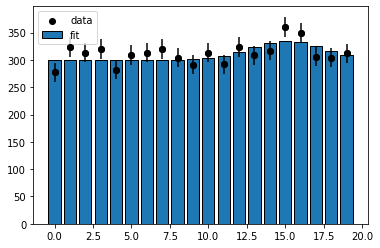

In [4]:
plt.bar(
    np.arange(20),
    m.expected_actualdata(bestfit),
    alpha=1.0,
    facecolor=None,
    edgecolor='k',
    label='fit',
)
plt.scatter(
    np.arange(20),
    d[: m.config.nmaindata],
    alpha=1.0,
    marker='o',
    c='k',
    label='data',
    zorder=99,
)
plt.errorbar(
    np.arange(20),
    d[: m.config.nmaindata],
    yerr=np.sqrt(d[: m.config.nmaindata]),
    marker='o',
    c='k',
    linestyle='',
)
plt.legend()